In [ ]:
import numpy as np
from casadi import *
import casadi as cs
import matplotlib.pyplot as plt
import seaborn as sns
from util import *
import itertools 
from time import perf_counter
import sympy as sym
from IPython.display import display, Math


In [ ]:
from decentralized import util

In [ ]:
%load_ext autoreload
%autoreload 2

## An example of using Casadi to optimize trajectory for a Human (modelled with a unicycle):

In [ ]:
Δt = sym.Symbol('\Delta t')
sθ = sym.Symbol('\sin \Theta')
cθ = sym.Symbol('\cos \Theta')
p_x, p_y, p_z, v, omega, theta, a = sym.symbols('p_x p_y p_z v omega theta a')

x = sym.Matrix([p_x, p_y, p_z, v])
u = sym.Matrix([theta, a])
display(Math('x = ' + sym.latex(x) + '\;u = ' + sym.latex(u)))

In [ ]:
x0 = np.array([0, 0, 1.7, 0.05, 0, 0])
xf = np.array([1.5,1.5,1.7,0, 0, 0])

Q = np.eye(6)*5
R = np.eye(3)*0.1
Qf = np.eye(6)*100

u_ref = np.array([0,0,0])

N = 100

opti = Opti()

dt = 0.05

In [ ]:
X = opti.variable(6,N+1)
U = opti.variable(3,N)

In [ ]:
f = lambda x,u: vertcat(x[3]*cos(u[0]),x[3]*sin(u[0]),0,u[1], 0, 0)

In [ ]:
for k in range(N): #loop over control intervals
    # Runge-Kutta 4 integration
    k1 = f(X[:,k],         U[:,k])
    k2 = f(X[:,k]+dt/2*k1, U[:,k])
    k3 = f(X[:,k]+dt/2*k2, U[:,k])
    k4 = f(X[:,k]+dt*k3,   U[:,k])
    x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

    opti.subject_to(X[:,k+1]==x_next) # close the gaps

In [ ]:
total_stage_cost = 0
for j in range(X.shape[1]-1):
    for i in range(X.shape[0]):
        total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

for j in range(U.shape[1]-1):
    for i in range(U.shape[0]):
        total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

#Quadratic terminal cost:
total_terminal_cost = 0
# for j in range(X.shape[1]):
for i in range(X.shape[0]):
    total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])

In [ ]:
objective = total_terminal_cost + total_stage_cost

In [ ]:
opti.minimize(objective) 

In [ ]:
opti.subject_to(X[0,:]<=3) # p_x is limited
opti.subject_to(-3<=X[0,:])

opti.subject_to(X[1,:]<=3) # p_y is limited
opti.subject_to(-3<=X[1,:])

opti.subject_to(X[3,:]<=5) # v is limited
opti.subject_to(-5<=X[3,:])

opti.subject_to(U[0,:]<=np.pi/2) # theta is limited
opti.subject_to(-np.pi/2<=U[0,:])

opti.subject_to(U[1,:]<=1) # a is limited
opti.subject_to(-1<=U[1,:]) 

#equality constraints:
opti.subject_to(X[:,0] == x0)
t0 = perf_counter()
opti.solver('ipopt');
sol = opti.solve()
tf = perf_counter()

print(f'total run time is {tf-t0} seconds')
X_trj = sol.value(X)
U_trj = sol.value(U)

In [ ]:
%matplotlib ipympl
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(X_trj[0,:],X_trj[1,:],X_trj[2,:])
ax.set_title('Trajectory from one-shot optimization (human)')


## Running inhomogenous test with 2 quadrotors and 1 human (receding-horizon):

In [ ]:
def objective(X,U,u_ref,xf,Q,R,Qf):
    total_stage_cost = 0
    for j in range(X.shape[1]-1):
        for i in range(X.shape[0]):
            total_stage_cost += (X[i,j]-xf[i])*Q[i, i]*(X[i,j]-xf[i])

    for j in range(U.shape[1]-1):
        for i in range(U.shape[0]):
            total_stage_cost += (U[i,j]-u_ref[i])*R[i, i]*(U[i,j]-u_ref[i])

    #Quadratic terminal cost:
    total_terminal_cost = 0

    for i in range(X.shape[0]):
        total_terminal_cost += (X[i,-1]-xf[i])*Qf[i, i]*(X[i,-1]-xf[i])
            
    return total_stage_cost + total_terminal_cost

In [ ]:
def generate_f_human_drone(x_dims_local,n_human):
    g = 9.8
    # NOTE: Assume homogeneity of agents.
    n_agents = len(x_dims_local)
    n_states = x_dims_local[0]
    n_controls = 3
    
    def f(x, u):
        x_dot = cs.MX.zeros(x.numel())
        for i_agent in range(0,n_agents-n_human):
            i_xstart = i_agent * n_states
            i_ustart = i_agent * n_controls
            x_dot[i_xstart:i_xstart + n_states] = cs.vertcat(
                x[i_xstart + 3: i_xstart + 6],
                g*cs.tan(u[i_ustart]), -g*cs.tan(u[i_ustart+1]), u[i_ustart+2] - g
                )
        # count = 0
        for j_agent in range(n_agents-n_human,n_agents):
            j_xstart = j_agent * n_states
            j_ustart = j_agent * n_controls #human agent has 2 control var.
            # if count > 0:
            #     j_ustart -=1
            # count +=1
            
            x_dot[j_xstart:j_xstart + n_states] = cs.vertcat(
                x[j_xstart + 3]*cs.cos(u[j_ustart]), x[j_xstart+3]*cs.sin(u[j_ustart]),0,
                u[j_ustart+1], 0 , 0
                )
            
        return x_dot
    
    return f

In [ ]:
#2 drones + 1 human:
n_agents = 3
n_humans = 1
n_states = 6
n_inputs = 3
n_dims = [3,3,2]
x_dims = [6,6,6]
u_dims = [3,3,3]

x0 = np.array([[0.5, 1.5, 1.5, 0, 0, 0,   #Drone
               2.5, 1.5, 1.5, 0, 0, 0,   #Drone
               1, 1, 1.7, 0.01, 0, 0]]).T #Human 

xf = np.array([[ 2.5, 1.5, 1.5, 0, 0, 0, 
                0.5, 1.5, 1.5, 0, 0, 0,
                2, 2, 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,0])

dt = 0.1

In [ ]:

# f = lambda x,u: vertcat(x[3],x[4],x[5],g*tan(u[0]),-g*tan(u[1]),u[2]-g,
#                     x[9],x[10],x[11], g*tan(u[3]), -g*tan(u[4]),u[5]-g,
#                     x[15]*cos(u[6]), x[15]*sin(u[6]), 0, u[7], 0, 0)
f = generate_f_human_drone(x_dims,n_humans)

In [ ]:
theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.5

max_input_base = np.array([[theta_max], [phi_max], [tau_max]])
min_input_base = np.array([[theta_min], [phi_min], [tau_min]])
max_state_base = np.array([[x_max], [y_max], [z_max], [v_max],[v_max], [v_max]])
min_state_base = np.array([[x_min], [y_min], [z_min], [v_min],[v_min], [v_min]])




# max_input_human = np.array([np.pi/2,2])
# min_input_human = np.array([-np.pi/2,-2])

# max_state_human = np.array([x_max,y_max,z_max,v_max,0,0])
# min_state_human = np.array([x_min,y_min,z_min,v_min,0,0])

In [ ]:
#actually it makes no sense to put constraints on the human agent; 
#human agent is assumed to be irrational

In [ ]:
radius = 0.65

In [ ]:
#Setting up constraints for the drones:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [ ]:
def solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,d_threshold,n_dims,u_dims):
    #N is the shifting prediction horizon
    
    p_opts = {"expand":True}
    s_opts = {"max_iter": 1000,"print_level":0}
    
    
    M = 200 # this is the entire fixed horizon
 
    n_x = n_agents*n_states
    # n_u = n_agents*n_inputs
    n_u = sum(u_dims)
    x_dims = [n_states]*n_agents
    
    X_full = np.zeros((0, n_x))
    U_full = np.zeros((0, n_u))
    
    t = 0

    J_list = []
    J_list.append(np.inf)
    # for i in range(M) :
    i = 0
    dt = 0.1
    
    while np.any(distance_to_goal(x0,xf,n_agents,n_states) > 0.1)  and (i < M):
        
        
        opti = Opti()
        
        X = opti.variable(n_x,N+1)
        U = opti.variable(n_u,N)
        
        cost_fun = objective(X,U,u_ref,xf,Q,R,Qf)
        opti.minimize(cost_fun)

        for k in range(N): #loop over control intervals
            # Runge-Kutta 4 integration
            k1 = f(X[:,k],         U[:,k])
            k2 = f(X[:,k]+dt/2*k1, U[:,k])
            k3 = f(X[:,k]+dt/2*k2, U[:,k])
            k4 = f(X[:,k]+dt*k3,   U[:,k])
            x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 

            opti.subject_to(X[:,k+1]==x_next) # close the gaps
    
            opti.subject_to(U[0:(n_agents-n_humans)*n_inputs,k] <= max_input)
            opti.subject_to(min_input <= U[0:(n_agents-n_humans)*n_inputs,k])
   
        #collision avoidance constraints
        for k in range(N+1):
            distances = compute_pairwise_distance_nd_Sym(X[:,k], x_dims,n_dims)
            opti.subject_to(X[0:(n_agents-n_humans)*n_states,k] <= max_state)
            opti.subject_to(min_state <= X[0:(n_agents-n_humans)*n_states,k])

            for n in range(len(distances)):
                opti.subject_to(distances[n] >= radius)
    
        #equality constraints for initial condition:
        opti.subject_to(X[:,0] == x0)
        
        opti.solver("ipopt",p_opts,
                    s_opts) 
        
        sol = opti.solve()
        # print(opti.debug.value)
        x0 = sol.value(X)[:,1].reshape(-1,1)
        # print(x0.shape)
        u_sol = sol.value(U)[:,0]
        
        J_list.append(sol.value(cost_fun))
        print(f'current objective function value is {sol.value(cost_fun)}')
        
        
        #Store the trajectory
        
        X_full = np.r_[X_full, x0.reshape(1,-1)]
        U_full = np.r_[U_full, u_sol.reshape(1,-1)]
        
        t += dt
        i +=1
        
        # print(opti.variable) #print this to check the optimization parameters for each control horizon
        
        if abs(J_list[i]-J_list[i-1]) <= 1.0 :
            print(f'Terminated! at i = {i}')
            break
            
        
    return X_full,U_full, t

In [ ]:
#equality constraints:
N = 10
t0 = perf_counter()
n_agents = 3
n_states = 6
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

In [ ]:
X_trj.shape

In [ ]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (IPOPT) (1 human & 2 drones)')
plt.savefig('results/one_human_2_drones.png')

In [ ]:
X_trj.shape

In [ ]:
#animate the plot:

import matplotlib.animation as animation


# first, fill X_trj with some test data


# second, create a function that updates the scatter plot for each frame
def update_plot(k, X_trj, scatters):
     # Set the data for each scatter plot
    scatters[0]._offsets3d = X_trj.T[0:3, :k]
    scatters[1]._offsets3d = X_trj.T[6:9, :k]
    scatters[2]._offsets3d = X_trj.T[12:15, :k]
    return scatters

# Create the figure and axis
fig = plt.figure()
ax = plt.axes(projection='3d')

# Create the scatter plots
scatters = []
scatters.append(ax.scatter([], [], []))
scatters.append(ax.scatter([], [], []))
scatters.append(ax.scatter([], [], []))

# set the axis limits
ax.set_xlim3d(X_trj.T[[0, 6, 12], :].min(), X_trj.T[[0, 6, 12], :].max())
ax.set_ylim3d(X_trj.T[[1, 7, 13], :].min(), X_trj.T[[1, 7, 13], :].max())
ax.set_zlim3d(X_trj.T[[2, 8, 14], :].min(), X_trj.T[[2, 8, 14], :].max())


# Set the title
ax.set_title('Trajectory from one-shot optimization (human + drones)')

ani = animation.FuncAnimation(fig, update_plot, frames=100, fargs=(X_trj, scatters))

ani.save('animation(1_human_2_drones).mp4')
plt.show()

## Running inhomogenous test with 3 quadrotors and 2 human (receding-horizon):

In [ ]:
paper_setup_3_quads()[1].T

In [41]:
#3 drones + 2 human:
n_agents = 5
n_states = 6
n_humans = 2
n_dims = [3,3,3,2,2]
x_dims = [6,6,6,6,6]
u_dims = [3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone
              1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone
              1, 1, 1.7, 0.01, 0, 0 , #Human 1
              2.1, 2.1, 1.7, -0.01, 0, 0]]).T # Human 2

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                1.5, 2.2, 1. , 0. , 0. , 0. , #Drone
                2., 2., 1.7, 0,  0,  0,  
                1., 1., 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,0,0,0,0])


opti = Opti()

dt = 0.1

In [42]:
x_dims

[6, 6, 6, 6, 6]

In [43]:
f = generate_f_human_drone(x_dims,n_humans)

In [44]:
max_input = np.tile(max_input_base,(n_agents-n_humans,1))
min_input = np.tile(min_input_base,(n_agents-n_humans,1))
max_state = np.tile(max_state_base,(n_agents-n_humans,1))
min_state = np.tile(min_state_base,(n_agents-n_humans,1))

In [45]:
u_dims

[3, 3, 3, 3, 3]

In [46]:
radius = 0.4
N = 15
t0 = perf_counter()
X_trj,u_trj, t = solve_rhc(x0,xf,u_ref,N,Q,R,Qf,n_agents,n_states,radius,n_dims,u_dims)
tf = perf_counter()
print(f'total run time is {tf-t0} seconds')

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)   1.33ms ( 11.31us)       118
       nlp_g  |        0 (       0)   4.20ms ( 35.58us)       118
  nlp_grad_f  |        0 (       0)   1.82ms ( 15.59us)       117
  nlp_hess_l  |        0 (       0)   7.72ms ( 67.15us)       115
   nlp_jac_g  |        0 (       0)   6.74ms ( 57.64us)       117
       total  |   5.61 s (  5.61 s) 943.29ms (943.29ms)         1
current objective function value is 1594.1959329993824
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 989.60us ( 11.00us)        90
       nlp_g  |        0 (       0)   3.08ms ( 34.17us)        90
  nlp_grad_f  |        0 (       0)   1.40ms ( 15.42us)        91
  nlp_hess_l  |        0 (       0)   5.92ms ( 66.48us)        89
   nlp_jac_g  |        0 (       0)   5.06ms ( 55.60us)        91
       total  |   4.25 s (  4.25 s) 741.44ms (741.44ms)         1
current objective fun

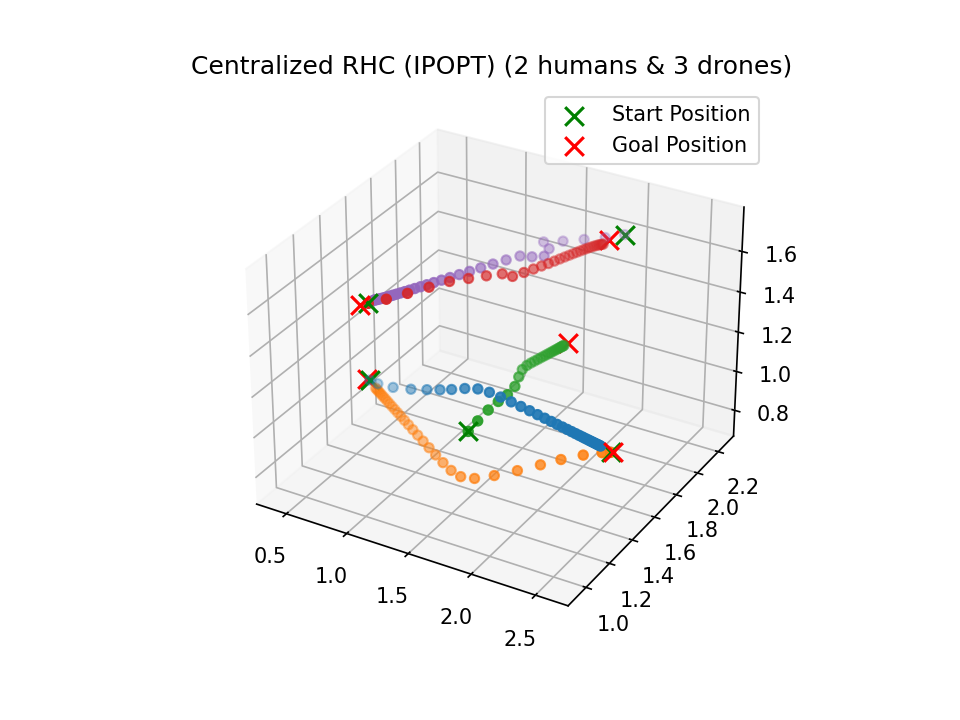

In [47]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_trj,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Centralized RHC (IPOPT) (2 humans & 3 drones)')
plt.savefig('results/two_human_3_drones.png')

## Solve the problem in distributed fashion:

In [31]:
#2 drones + 1 human:
n_agents = 3
n_humans = 1
n_states = 6
n_inputs = 3
n_dims = [3,3,2]
x_dims = [6,6,6]
u_dims = [3,3,3]

x0 = np.array([[0.5, 1.5, 1.5, 0, 0, 0,   #Drone
               2.5, 1.5, 1.5, 0, 0, 0,   #Drone
               1, 1, 1.7, 0.01, 0, 0]]).T #Human 

xf = np.array([[ 2.5, 1.5, 1.5, 0, 0, 0, 
                0.5, 1.5, 1.5, 0, 0, 0,
                2, 2, 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,0])

dt = 0.1

theta_max = np.pi / 6
phi_max = np.pi / 6

v_max = 3
v_min = -3

theta_min = -np.pi / 6
phi_min = -np.pi / 6

tau_max = 15
tau_min = 0

x_min = -5
x_max = 5

y_min = -5
y_max = 5

z_min = 0
z_max = 3.5

radius = 0.5

ids = [100 + i for i in range(n_agents)]

In [32]:
from distributed_mpc import solve_rhc_distributed

In [33]:

X_full, U_full, t, J_list, failed_count, converged = solve_rhc_distributed(
    0,x0, xf, u_ref, N, n_agents, n_states, n_inputs, radius, ids,\
    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
  theta_min,tau_max,tau_min,phi_max,phi_min,n_dims=[3,3,2])

determining interaction graph with the following pair-wise distance : [[2.    0.908 1.781]]
current interaction graph is {100: [100, 102], 101: [101], 102: [100, 102]}, the pairwise distances between each agent is [2.000249984376953, 0.9078135347674556, 1.7814550262337527]
Solving the 0th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6, 6]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 142.50us (  4.60us)        31
       nlp_g  |        0 (       0) 304.70us (  9.83us)        31
  nlp_grad_f  |        0 (       0) 176.20us (  5.51us)        32
  nlp_hess_l  |        0 (       0) 355.00us ( 11.83us)        30
   nlp_jac_g  |        0 (       0) 484.90us ( 15.15us)        32
       total  |  78.12ms ( 78.12ms)  81.91ms ( 81.91ms)         1
objective value for the 0th subproblem at iteration 0 is 10373.457390181786
Solving the 1th sub-problem at iteration 0, t = 0
current sub-problem has state dimension

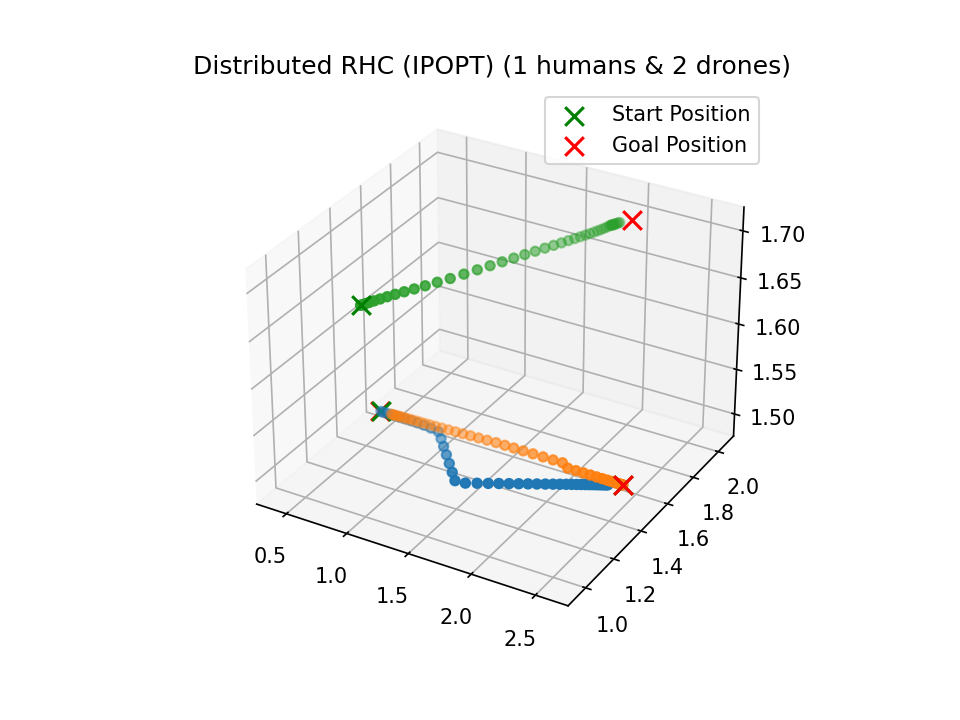

In [35]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Distributed RHC (IPOPT) (1 humans & 2 drones)')
plt.savefig('results/one_human_2_drones.png')

In [52]:
#3 drones + 2 human:
n_agents = 5
n_states = 6
n_humans = 2
n_dims = [3,3,3,2,2]
x_dims = [6,6,6,6,6]
u_dims = [3,3,3,3,3]

x0 = np.array([[0.5, 1.5, 1. , 0. , 0. , 0. ,   #Drone
               2.5, 1.5, 1. , 0. , 0. , 0.,   #Drone
              1.5, 1.3, 1. , 0. , 0. , 0.,  #Drone
              1, 1, 1.7, 0.01, 0, 0 , #Human 1
              2.1, 2.1, 1.7, -0.01, 0, 0]]).T # Human 2

xf = np.array([[ 2.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                0.5, 1.5, 1. , 0. , 0. , 0. , #Drone
                1.5, 2.2, 1. , 0. , 0. , 0. , #Drone
                2., 2., 1.7, 0,  0,  0,  
                1., 1., 1.7, 0,  0,  0]]).T

Q = np.eye(n_agents*n_states)*10
R = np.eye(sum(u_dims))*0.1
Qf = np.eye(n_agents*n_states)*100
g = 9.81
u_ref = np.array([0,0,g,0,0,g,0,0,g,0,0,0,0,0,0])

radius = 0.35

N = 15

In [53]:
ids = [100 + i for i in range(n_agents)]
X_full, U_full, t, J_list, failed_count, converged = solve_rhc_distributed(
    0,x0, xf, u_ref, N, n_agents, n_states, n_inputs, radius, ids,\
    x_min,x_max,y_min,y_max,z_min,z_max,v_min,v_max,theta_max,\
  theta_min,tau_max,tau_min,phi_max,phi_min,n_dims)

determining interaction graph with the following pair-wise distance : [[2.    1.02  0.908 1.909 1.02  1.781 0.922 0.784 1.2   1.756]]
current interaction graph is {100: [100], 101: [101], 102: [102], 103: [103], 104: [104]}, the pairwise distances between each agent is [2.000249984376953, 1.0202940752547767, 0.9078135347674556, 1.90909332688417, 1.0202940752547767, 1.7814550262337527, 0.9218032973047436, 0.7839520528262574, 1.200499875062461, 1.7559562975867928]
Solving the 0th sub-problem at iteration 0, t = 0
current sub-problem has state dimension : [6]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  60.40us (  5.03us)        12
       nlp_g  |        0 (       0)  81.30us (  6.77us)        12
  nlp_grad_f  |        0 (       0)  57.80us (  4.45us)        13
  nlp_hess_l  |        0 (       0)  81.20us (  7.38us)        11
   nlp_jac_g  |        0 (       0) 124.30us (  9.56us)        13
       total  |  31.25ms ( 31.25ms)  23.6

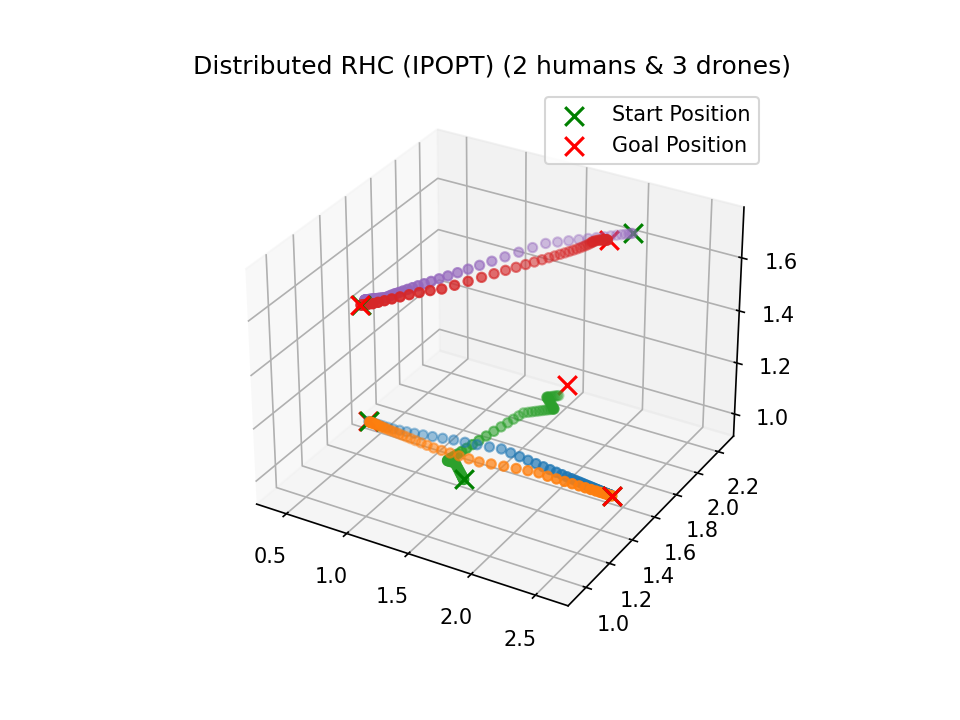

In [55]:
%matplotlib ipympl
plt.figure(dpi=150)
util.plot_solve(X_full,10,xf,x_dims,True,3)
ax = plt.gca()
ax.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
plt.title('Distributed RHC (IPOPT) (2 humans & 3 drones)')
plt.savefig('results/two_human_3_drones_distributed.png')